Adicionando o banco

In [79]:
import pandas as pd
import numpy as np

# Carregar o CSV
raw_path = "kendo_matches_work.csv"
df = pd.read_csv(raw_path)

print("Shape original:", df.shape)
display(df.head())

Shape original: (202, 9)


,Unnamed: 0,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,1,0,1,0,0,0
1,2,1,2,5,1,0,1,0,0
2,3,2,1,10,0,0,1,0,0
3,4,2,2,48,0,1,0,0,0
4,5,3,1,38,0,1,0,0,0


In [80]:
# Remover coluna-índice exportada por engano
idx_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
if idx_cols:
    df = df.drop(columns=idx_cols)
    print(f"Removidas colunas de índice exportado: {idx_cols}")

Removidas colunas de índice exportado: ['Unnamed: 0']


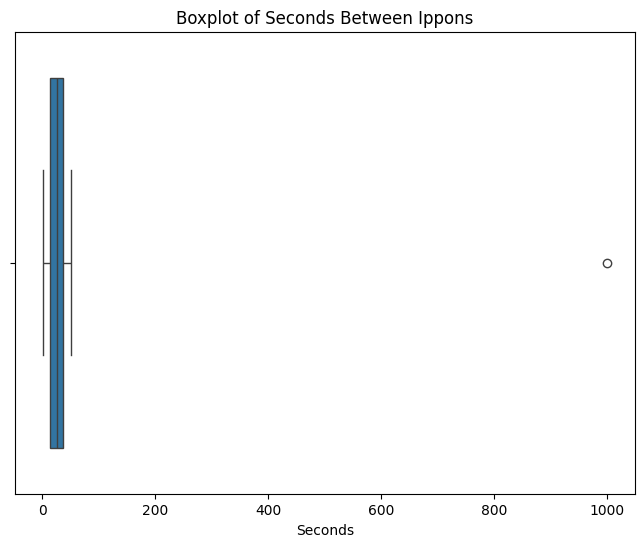

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for the 'seconds_between' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['seconds_between'])
plt.title('Boxplot of Seconds Between Ippons')
plt.xlabel('Seconds')
plt.show()

In [82]:
# Padronização de tipos / mapeamento de valores
# Colunas esperadas
expected_cols = [
    "match_id", "ippon_number", "seconds_between", "ippon_taken",
    "men", "kote", "do", "tsuki"
]

# Verificar se todas existem (se faltar, acuse para evitar erro silencioso)
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Colunas ausentes no CSV: {missing}")

In [83]:
# Remover espaços em branco em strings
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

In [84]:
# Mapeamento de strings comuns para binário
# (O/o -> 0, I/l/| -> 1, yes/true/y -> 1, no/false/n -> 0)
binary_map = {
    "o": 0, "O": 0, "0": 0, "no": 0, "false": 0, "n": 0,
    "i": 1, "I": 1, "l": 0, "|": 1, "1": 1, "yes": 1, "true": 1, "y": 1
}


In [85]:
bin_cols = ["men", "kote", "do", "tsuki", "ippon_taken"]

for col in bin_cols:
    # aplica mapeamento em valores de texto conhecidos
    df[col] = df[col].replace(binary_map)
    # convert to Int64 after replacement, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors="coerce").astype('Int64')

C:\Users\biels\AppData\Local\Temp\ipykernel_14840\728424066.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(binary_map)


In [86]:
# Convert all columns to numeric first, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now convert to Int64, which can handle NaNs
for col in df.columns:
    df[col] = df[col].astype('Int64')

In [87]:
# Validar campos binários (0/1)
# Qualquer valor que não seja 0 ou 1 nas colunas binárias será considerado erro -> NaN
for col in bin_cols:
    df.loc[~df[col].isin([0, 1]), col] = np.nan

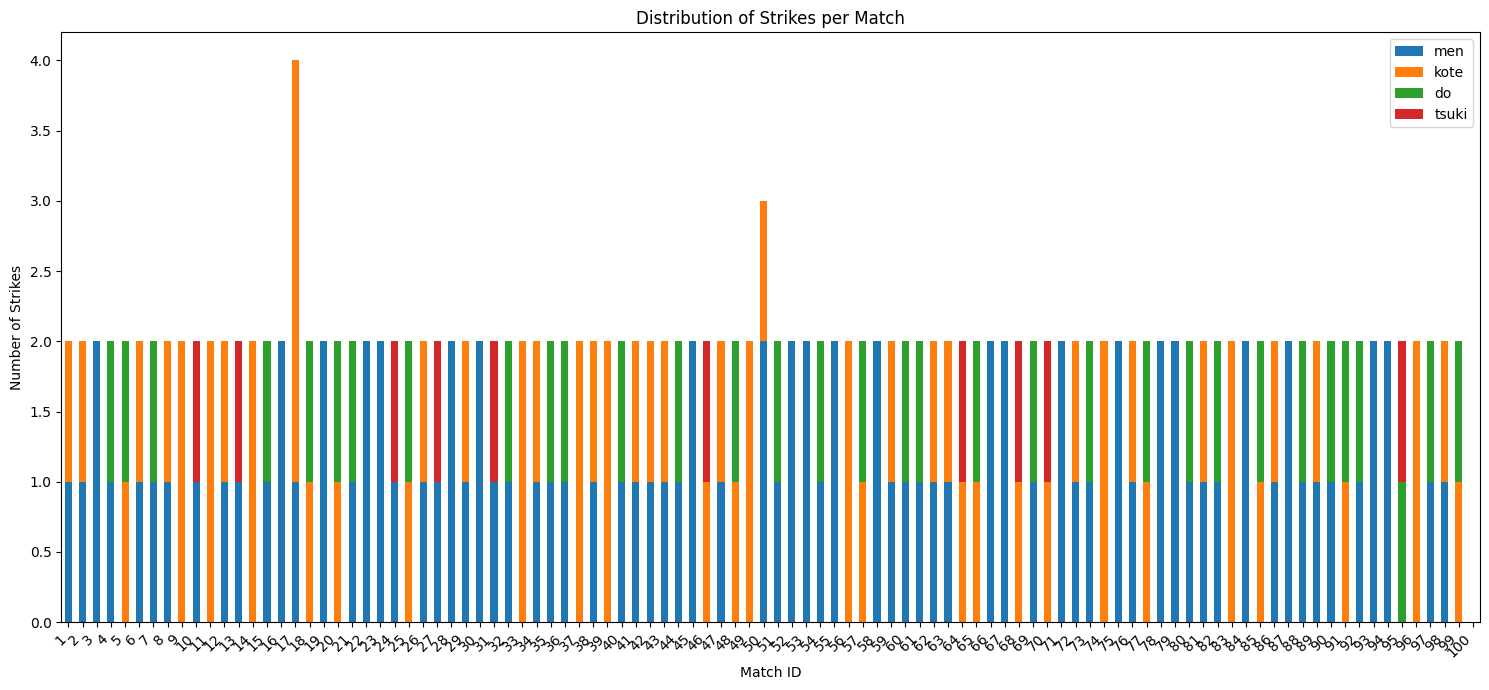

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']].sum()

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [89]:
# Dropar linhas que possuem seconds_between maiores que 300s (tempo de partida)
before_drop = df.shape[0]
df = df[df['seconds_between'] <= 300].copy()
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

Número de linhas antes de remover: 202
Número de linhas depois de remover: 201


In [90]:
# Dropar linhas duplicadas
dup_before = df.shape[0]
df = df.drop_duplicates().copy()
dup_after = df.shape[0]

print(f"Número de linhas antes de dropar duplicadas: {dup_before}")
print(f"Número de linhas depois de dropar duplicadas: {dup_after}")

Número de linhas antes de dropar duplicadas: 201
Número de linhas depois de dropar duplicadas: 200


In [91]:
# Retirar partidas que não possuem valor verdadeiro nos golpes
# Criar uma máscara para identificar linhas onde a soma das colunas de golpe é 0 (ou NaN)
strike_cols = ["men", "kote", "do", "tsuki"]
# Check if the sum of strikes is 0 or NaN (assuming 1 for a valid strike)
mask_no_strike = (df[strike_cols].sum(axis=1) == 0) | (df[strike_cols].sum(axis=1).isna())

# Get the number of rows before dropping
before_drop = df.shape[0]

# Drop the rows where the mask is True
df = df[~mask_no_strike].copy()

# Get the number of rows after dropping
after_drop = df.shape[0]

print(f"Número de linhas antes de remover: {before_drop}")
print(f"Número de linhas depois de remover: {after_drop}")

display(df.head())

Número de linhas antes de remover: 200
Número de linhas depois de remover: 198


,match_id,ippon_number,seconds_between,ippon_taken,men,kote,do,tsuki
0,1,1,1,0,1,0,0,0
1,1,2,5,1,0,1,0,0
2,2,1,10,0,0,1,0,0
3,2,2,48,0,1,0,0,0
4,3,1,38,0,1,0,0,0


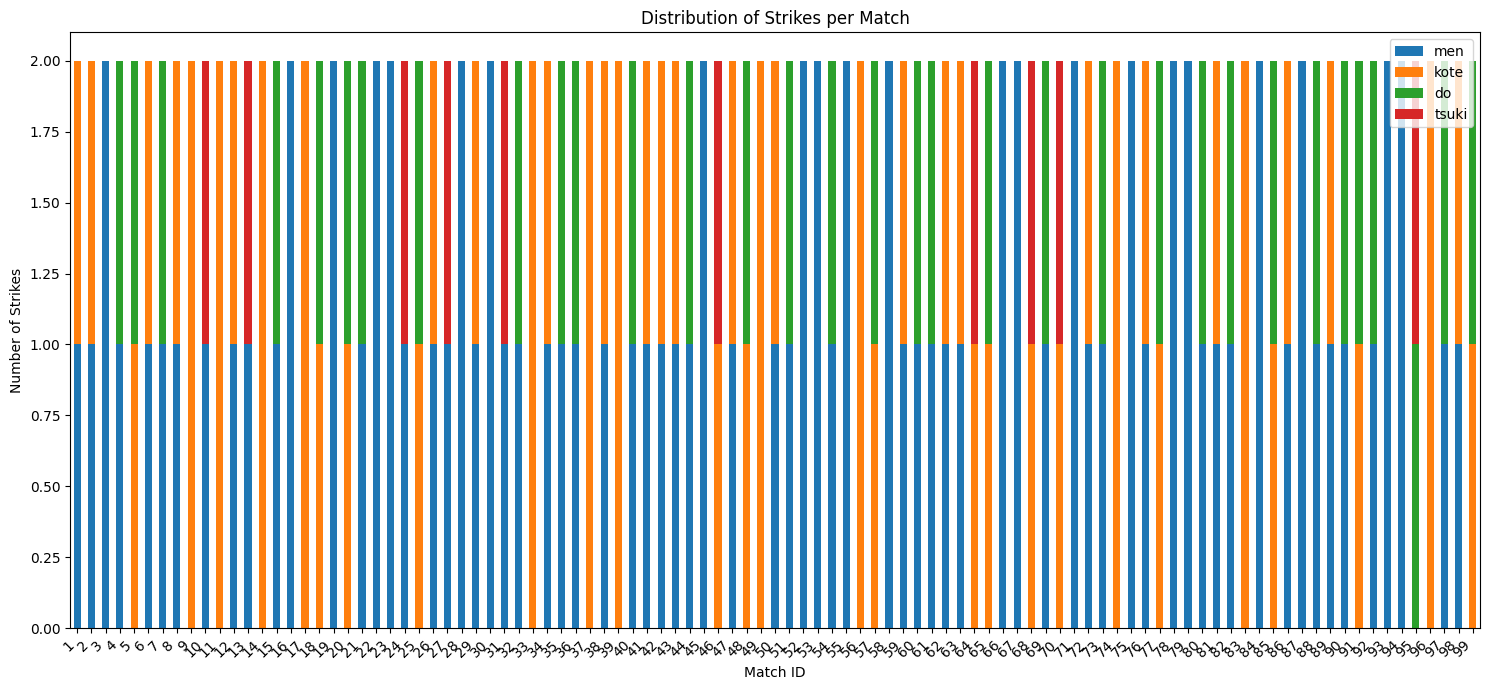

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by match_id and sum the strike counts
strike_summary = df.groupby('match_id')[['men', 'kote', 'do', 'tsuki']].sum()

# Create a stacked bar plot
strike_summary.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Distribution of Strikes per Match')
plt.xlabel('Match ID')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [93]:
# Salvar CSV limpo
clean_path = "kendo_matches_TRATADOS.csv"
df.to_csv(clean_path, index=False)
print(f"\nArquivo salvo em: {clean_path}")


Arquivo salvo em: kendo_matches_TRATADOS.csv


MINEIRANDO UHUUU

P1

In [98]:
# ==============================
# P1 - Golpe que implica no NÃO uso de outro golpe
# ==============================

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Carrega o dataset tratado
df = pd.read_csv("kendo_matches_TRATADOS.csv")

# Seleciona apenas colunas de golpes (ajuste se tiver nomes diferentes)
golpes_cols = ["men", "kote", "do", "tsuki"]

# Garante binarização: 1 = golpe usado, 0 = não usado
df_bin = df[golpes_cols].applymap(lambda x: 1 if x >= 1 else 0)

# Cria colunas de "não uso" (ex: Men_0 significa que o golpe NÃO foi usado)
for col in golpes_cols:
    df_bin[col + "_0"] = 1 - df_bin[col]

# Aplica Apriori para encontrar conjuntos frequentes
frequent_itemsets = apriori(df_bin, min_support=0.05, use_colnames=True)

# Gera regras de associação
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)

# Filtra regras da forma: golpe usado -> golpe não usado
rules_p1 = rules[
    (rules['confidence'] > 0.9) &
    (rules['antecedents'].apply(lambda x: any(item in golpes_cols for item in x))) &
    (rules['consequents'].apply(lambda x: any("_0" in item for item in x)))
]

print("Regras com confiança > 90%:")
print(rules_p1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Regras com confiança > 90%:
               antecedents            consequents   support  confidence  \
0                    (men)               (kote_0)  0.469697         1.0   
1                    (men)                 (do_0)  0.469697         1.0   
2                    (men)              (tsuki_0)  0.469697         1.0   
3                   (kote)                (men_0)  0.313131         1.0   
4                   (kote)                 (do_0)  0.313131         1.0   
..                     ...                    ...       ...         ...   
81  (kote_0, men_0, tsuki)                 (do_0)  0.050505         1.0   
82           (do_0, tsuki)        (kote_0, men_0)  0.050505         1.0   
83         (kote_0, tsuki)          (do_0, men_0)  0.050505         1.0   
84          (men_0, tsuki)         (do_0, kote_0)  0.050505         1.0   
85                 (tsuki)  (do_0, kote_0, men_0)  0.050505         1.0   

         lift  
0    1.455882  
1    1.200000  
2    1.053191  
3    1.

C:\Users\biels\AppData\Local\Temp\ipykernel_14840\3721501017.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bin = df[golpes_cols].applymap(lambda x: 1 if x >= 1 else 0)
C:\Users\biels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


P2

In [102]:
# ==============================
# P2 - Confiança da regra: Men=1 -> ippon_taken=1
# ==============================

import pandas as pd
import numpy as np

# Carrega o dataset tratado
df = pd.read_csv("kendo_matches_TRATADOS.csv")

# --- Seleção direta das colunas ---
# Ajuste os nomes se no seu CSV forem diferentes
men = df["men"].fillna(0).astype(int)
ippon_taken = df["ippon_taken"].fillna(0).astype(int)

# Binariza: 1 se aplicou pelo menos 1 MEN, 0 caso contrário
men = (men >= 1).astype(int)

# Binariza: 1 se levou ippon, 0 caso contrário
ippon_taken = (ippon_taken >= 1).astype(int)

# ---------- Métricas ----------
n = len(df)
antecedent_count = (men == 1).sum()
both_count = ((men == 1) & (ippon_taken == 1)).sum()
consequent_count = (ippon_taken == 1).sum()

confidence = both_count / antecedent_count if antecedent_count > 0 else np.nan
support_rule = both_count / n
support_antecedent = antecedent_count / n
support_consequent = consequent_count / n
lift = confidence / support_consequent if support_consequent > 0 else np.nan

# ---------- Saída ----------
print("\nRegra avaliada:  { Men = 1 }  ->  { ippon_taken = 1 }")
print(f"Confiança: {confidence:.4f}  (P(ippon_taken=1 | Men=1))")
print(f"Suporte da regra: {support_rule:.4f}")
print(f"Suporte antecedente (Men=1): {support_antecedent:.4f}")
print(f"Suporte consequente (ippon_taken=1): {support_consequent:.4f}")
print(f"Lift: {lift:.4f}")



Regra avaliada:  { Men = 1 }  ->  { ippon_taken = 1 }
Confiança: 0.4516  (P(ippon_taken=1 | Men=1))
Suporte da regra: 0.2121
Suporte antecedente (Men=1): 0.4697
Suporte consequente (ippon_taken=1): 0.4394
Lift: 1.0278


P3

In [103]:
# ==============================
# P3 - Golpes com >85% de confiança de ocorrerem >25s após o 1º golpe
# Usando a coluna: seconds_between
# ==============================

import pandas as pd
import numpy as np

df = pd.read_csv("kendo_matches_TRATADOS.csv")

# Colunas dos golpes (em minúsculas)
golpes_cols = ["men", "kote", "do", "tsuki"]

# Binariza golpes: 1 se ocorreu (>=1), 0 caso contrário
df_bin = (df[golpes_cols].fillna(0).astype(float) >= 1).astype(int)

# Condição alvo: intervalo entre 1º e 2º golpe > 25s
seconds_between = pd.to_numeric(df["seconds_between"], errors="coerce")
cond_apos25 = (seconds_between > 25)

# Calcula confiança por golpe: P(seconds_between>25 | golpe=1)
resultados = []
n = len(df)
sup_conseq = cond_apos25.mean()  # P(cond)

for g in golpes_cols:
    antecedente = df_bin[g] == 1
    a = antecedente.sum()
    if a == 0:
        conf = np.nan
        sup_rule = np.nan
        lift = np.nan
    else:
        both = (antecedente & cond_apos25).sum()
        conf = both / a
        sup_rule = both / n
        lift = conf / sup_conseq if sup_conseq > 0 else np.nan

    resultados.append({
        "golpe": g,
        "confianca": conf,
        "suporte_regra": sup_rule,
        "lift": lift,
        "total_golpe": a
    })

res = pd.DataFrame(resultados).sort_values("confianca", ascending=False)

# Filtra e exibe golpes com confiança > 85%
print("Golpes com confiança > 85% (seconds_between > 25):")
print(res[res["confianca"] > 0.85])

print("\nTodas as métricas (ordenado por confiança):")
print(res)


Golpes com confiança > 85% (seconds_between > 25):
Empty DataFrame
Columns: [golpe, confianca, suporte_regra, lift, total_golpe]
Index: []

Todas as métricas (ordenado por confiança):
   golpe  confianca  suporte_regra      lift  total_golpe
3  tsuki   0.700000       0.035354  1.372277           10
2     do   0.545455       0.090909  1.069307           33
0    men   0.537634       0.252525  1.053976           93
1   kote   0.419355       0.131313  0.822102           62
